In [59]:

#warnings.filterwarnings(action='ignore')

from pmdarima.arima import auto_arima
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE #Recursive Feature Elimination
import numpy as np
import pandas as pd


def rolling_rf_data_pre(data,col='s0l2'):  #data weekly

    #data=df.copy()
    for j in range(1,len(data.columns)):
        data.iloc[:,j]=data.iloc[:,j]/data.iloc[:,-1]
    
    data['time']=pd.to_datetime(data['time'])
    data_month=data.groupby(pd.Grouper(key='time',freq='M')) \
                .mean().reset_index().sort_values('time')
    
    #data_month=data_month.set_index('time')
   
    
    
    lags = pd.DataFrame()
    #lags['time']=data_month['time'].copy()
    for i in range(12,3,-1):
        lags['t-'+str(i)] = data_month[col].shift(i)
    lags['t'] = data_month[col].values
    lags = lags[15:]


    array = lags.values
    X = array[:,0:-1]
    y = array[:,-1]
   
    #print(X)
    rfe = RFE(RandomForestRegressor(n_estimators=15, random_state=0), 8)
    fit = rfe.fit(X, y)
    names = lags.columns
    columns_pre=[]
    for i in range(len(fit.support_)):
        if fit.support_[i]:
            columns_pre.append(names[i])

    #print("Columns with predictive power:", columns_pre )
    
    df_forecasting_col=['time',col]
    df_forecasting_col.extend(['week -'+str(i) for i in range(1,9)])
    df_forecasting=pd.DataFrame(columns=df_forecasting_col)
    df_forecasting[col]=data_month[col].copy()
   
    df_forecasting['time']=data_month['time'].copy()
    for i in columns_pre:
        df_forecasting[i] = df_forecasting[col].shift(int(i[2:]))
    for i in range(6,3,-1):
        df_forecasting['t-'+str(i)] = df_forecasting[col].shift(i)

    
    for row in range(df_forecasting.shape[0]):
        
        data_week_past=(data[data['time']<
                             df_forecasting.iloc[row]['time']-pd.DateOffset(weeks=3)][col]).rolling(6).mean()
        #print(data_week_past.tail())
        
        if data_week_past.shape[0]>9:
            #print('yes')
            for i in range(1,9):
             #   print(data_week_past.iloc[-i])
                df_forecasting.at[row,'week -'+str(i)] = data_week_past.iloc[-i]
    df_forecasting= df_forecasting.dropna()
    df_forecasting.set_index('time',inplace=True)
    return  df_forecasting


def forecast_rf(df_forecasting,last_feature):
    
    
    x=df_forecasting.iloc[:,1:].copy()
    #print(x.shape)
    y=df_forecasting.iloc[:,0].copy()
    
    mdl=RandomForestRegressor(n_estimators=15,random_state=0,min_samples_leaf=2)

    mdl.fit(x,y)
    #print('y',y)
    model_fit= mdl.predict(x)
    #print('m',model_fit)
    x_current=np.asarray(last_feature).reshape(1, -1) 
    forecast= mdl.predict(x_current)
    return df_forecasting.index,model_fit,forecast



def forescast_feature_pre(data,df_forecasting,col='s0l2'):
    for j in range(1,len(data.columns)-1):
        data.iloc[:,j]=data.iloc[:,j]/data.iloc[:,-1]
    pop=(data[col].copy()).rolling(6).mean()
    #print(pop)
    feature=list(pop[-8:])
    lag_t=df_forecasting.columns[9:]
    #t-12
    
    pop_month=df_forecasting[col]
    
    for t in lag_t:
        t_index=-int(t[2:])
        feature.append(pop_month[t_index])
    return feature
    
    
    
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,# 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


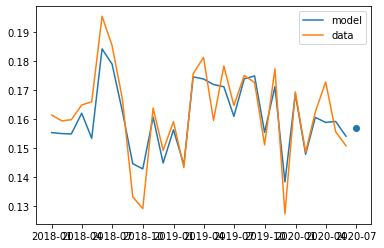

In [62]:
import matplotlib.pyplot as plt

col_test='s0l2'
data=pd.read_csv("data_final_hsl_cat_weekly.csv")
data.drop(columns='Unnamed: 0',inplace=True)
df_forecasting=rolling_rf_data_pre(data,col=col_test)
f=forescast_feature_pre(data,df_forecasting,col=col_test)
t,model,pred=forecast_rf(df_forecasting,f)


plt.plot(t[-30:],model[-30:],label='model')
plt.plot(t[-30:],df_forecasting[col_test][-30:],label='data')
plt.scatter(pd.to_datetime("2020-06-30"),pred)
plt.legend()


In [123]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=t[-30:], y=model[-30:],
                         mode='lines', name='model & forecast',line=dict(color="#80bf40",dash='dot')))
fig.add_trace(go.Scatter(x=t[-30:], y=df_forecasting[col_test][-30:],
                          mode='lines', name='data',line=dict(color="#409fbf")))
forecast_x=[t[-1],pd.to_datetime("2020-06-30")]
forecast_y=[model[-1],pred[0]]
fig.add_trace(go.Scatter(x=forecast_x,y=forecast_y,
                        mode='lines',line=dict(color="#80bf40",dash='dot'),showlegend=False))


fig.update_layout(
    title="S0L2",
    width=800,
    height=500,
    xaxis_title="time",
    yaxis_title="% popularity",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

#fig.write_image("forecast_s0l2.png")

In [84]:
fig.add_trace?

In [103]:
forecast_y

array([0.15527357, 0.15493497, 0.15482785, 0.16194806, 0.15332237,
       0.18408815, 0.17886547, 0.16254143, 0.14458145, 0.14280155,
       0.16058855, 0.14481743, 0.15627665, 0.14416969, 0.17448157,
       0.17373685, 0.17183062, 0.17106552, 0.1608758 , 0.1737883 ,
       0.17478593, 0.15536765, 0.17108927, 0.1383286 , 0.16855055,
       0.14783341, 0.1605303 , 0.15879144, 0.15912777, 0.15402901,
       0.15695515])

In [108]:
t[-30:].values.append(pd.to_datetime("2020-06-30"))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [109]:
t[-30:].values

array(['2017-12-31T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
       '2018-02-28T00:00:00.000000000', '2018-03-31T00:00:00.000000000',
       '2018-04-30T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
       '2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
       '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
       '2019-02-28T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
       '2019-04-30T00:00:00.000000000', '2019-05-31T00:00:00.000000000',
       '2019-06-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
       '2019-08-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-10-31T00:00:00.000000000', '2019-11-30T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-31